In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.spatial.distance import cdist
import math
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
finalLL = {}
def readData(dire):
    Data = {}
    i = 0
    for fname in os.scandir(dire):
        if fname.is_file():
            rate, samples = wavfile.read(fname.path)
            temp = Spectro(rate, samples).T
            Data.update({i: np.array(temp, copy=True)})
            i = i + 1
    return Data

def Spectro(rate, samples):
    total = int((len(samples) - rate * 0.025) / (rate * 0.01) + 1)
    spectro = np.zeros((int(64 / 2), total), dtype=complex)
    for i in range(total):
        value = np.fft.fft(np.hamming(400) * samples[int(i * 0.01 * rate):int(i * 0.01 * rate) + int(0.025 * rate)], 64)
        spectro[:, i] = value[0:int(64 / 2)]
    return np.log(np.absolute(spectro))


def plot(x,y, title):
    plt.plot(x, y)
    plt.xlabel('x - axis (Iteration Count)')
    plt.ylabel('y - axis (Loglikelihood value)')
    plt.title(title)
    plt.show()

def backward(observation,emission, transition,c):
    T=observation.shape[0]
    beta=np.array([[0.0]*3]*T)
    for t in range(T-1,-1,-1):
        if t == T-1:
            for i in range(0,3):
                beta[t][i]=1.0
            for i in range(0, 3):
                beta[t][i] = beta[t][i] * c[t]
        else:
            for i in range(0,3):
                count = 0
                for j in range(0, 3):
                    count=count+transition[i][j]*emission[j][observation[t+1]]*beta[t+1][j]
                beta[t][i]=count
            for i in range(0, 3):
                beta[t][i] = beta[t][i] * c[t]
    return beta


def forward(observation, prior, emission, transition):
    T = observation.shape[0]
    alpha = np.array([[0.0, 0.0, 0.0]] * T)
    c = np.array([0.0] * T)
    for t in range(0, T):
        if t == 0:
            den = 0
            for i in range(0, 3):
                alpha[t][i] = emission[i][observation[t]] * prior[i]
                den = den + alpha[t][i]
            c[t] = 1 / den
            for i in range(0, 3):
                alpha[t][i] = alpha[t][i] * c[t]
        else:
            den = 0
            for j in range(0, 3):
                count = 0
                for i in range(0, 3):
                    count = count + alpha[t - 1][i] * transition[i][j]
                alpha[t][j] = count * emission[j][observation[t]]
                den = den + alpha[t][j]
            c[t] = 1 / den
            for i in range(0, 3):
                alpha[t][i] = alpha[t][i] * c[t]
    finalprob = 0
    for i in range(0, T):
        finalprob = finalprob + math.log(c[i])
    return alpha, (0 - finalprob), c

def calculateGamma(alpha, beta):
    T = alpha.shape[0]
    N = alpha.shape[1]
    gamma = np.array([[0.0] * N] * T)
    for t in range(0, T):
        sum = 0
        for i in range(0, N):
            gamma[t][i] = alpha[t][i] * beta[t][i]
            sum = sum + gamma[t][i]
        for i in range(0, N):
            gamma[t][i] = gamma[t][i] / sum
    return gamma


def calcualtePsi(alpha, beta, A, b, observation):
    psi = {}
    N = alpha.shape[1]
    T = alpha.shape[0]
    for t in range(0, T - 1):
        temp = np.array([[0.0] * N] * N)
        sum = 0
        for i in range(0, N):
            for j in range(0, N):
                temp[i][j] = alpha[t][i] * A[i][j] * b[j][observation[t + 1]] * beta[t + 1][j]
                sum = sum + temp[i][j]
        for i in range(0, N):
            for j in range(0, N):
                temp[i][j] = temp[i][j] / sum
        psi.update({t: temp})
    return psi

def EMAlgorithm(data, initprior, initemission, inittransition):
    N = 3
    T = data[0].shape[0]
    E = len(data)
    print("EM Algorithm started")
    itr = 0
    transition = inittransition
    emission = initemission
    prior = initprior
    finalLL.clear()
    while itr < 20:
        print("Iteration number: ", itr)
        alpha = {}
        beta = {}
        gamma = {}
        psi = {}
        likeli = {}
        for i in data:
            tempa, temp, c = forward(data[i], prior, emission, transition)
            likeli.update({i: temp})
            tempb = backward(data[i],emission, transition,c)
            tempg = calculateGamma(tempa, tempb)
            tempp = calcualtePsi(tempa, tempb, transition, emission, data[i])
            alpha.update({i: tempa})
            beta.update({i: tempb})
            gamma.update({i: tempg})
            psi.update({i: tempp})
        s = 0
        for e in range(0, len(data)):
            s = s + likeli[e]
        finalLL.update({itr: s})
        print("Total likelihood: ",s)
        itr = itr + 1
        transitionNext = np.array([[0.0] * N] * N)
        emissionNext = np.array([[0.0] * 8] * N)

        # Calculating transitions
        for i in range(0, N):
            for j in range(0, N):
                num = 0
                den = 0
                for e in range(0, E):
                    for t in range(0, T - 1):
                        num = num + psi[e][t][i][j]
                        den = den + gamma[e][t][i]
                transitionNext[i][j] = num / den
        # Calculating emissions
        for i in range(0, N):
            for o in range(0, 8):
                num = 0
                den = 0
                for e in range(0, E):
                    for t in range(0, T):
                        num = num + (int(data[e][t] == o) * gamma[e][t][i])
                        den = den + gamma[e][t][i]
                emissionNext[i][o] = num / den
        # Calculating priors
        priorNext = np.array([0.0] * N)
        for i in range(0,N):
            for e in range(0, E):
                priorNext[i]=gamma[e][0][i]
        for i in range(0,N):
            priorNext[i] = priorNext[i] / E

        transition = transitionNext
        emission = emissionNext
        prior = priorNext

    return prior, transition, emission

EM Algorithm started
Iteration number:  0
Total likelihood:  -253905.75059228315
Iteration number:  1
Total likelihood:  -218036.09985430166
Iteration number:  2
Total likelihood:  -215004.30722187736
Iteration number:  3
Total likelihood:  -211500.1017571339
Iteration number:  4
Total likelihood:  -206911.78209878135
Iteration number:  5
Total likelihood:  -201769.5853248681
Iteration number:  6
Total likelihood:  -198579.11346109275
Iteration number:  7
Total likelihood:  -197311.27932593884
Iteration number:  8
Total likelihood:  -196766.80971646786
Iteration number:  9
Total likelihood:  -196521.28518890674
Iteration number:  10
Total likelihood:  -196376.86884097572
Iteration number:  11
Total likelihood:  -196297.8137261044
Iteration number:  12
Total likelihood:  -196278.42735123314
Iteration number:  13
Total likelihood:  -196271.9096312445
Iteration number:  14
Total likelihood:  -196268.29130571653
Iteration number:  15
Total likelihood:  -196266.39170619013
Iteration number:

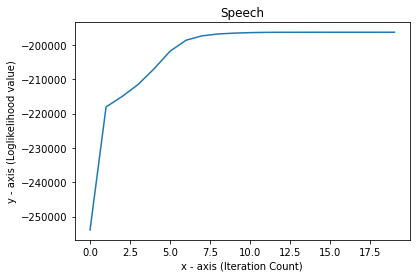

EM Algorithm started
Iteration number:  0
Total likelihood:  -252321.71166566107
Iteration number:  1
Total likelihood:  -210538.30400450868
Iteration number:  2
Total likelihood:  -210155.25719800644
Iteration number:  3
Total likelihood:  -209975.09803616008
Iteration number:  4
Total likelihood:  -209833.58877164416
Iteration number:  5
Total likelihood:  -209698.5496739001
Iteration number:  6
Total likelihood:  -209553.6365731183
Iteration number:  7
Total likelihood:  -209383.09640366066
Iteration number:  8
Total likelihood:  -209166.06733097858
Iteration number:  9
Total likelihood:  -208870.00825773404
Iteration number:  10
Total likelihood:  -208440.93184201693
Iteration number:  11
Total likelihood:  -207792.54520055547
Iteration number:  12
Total likelihood:  -206809.04145429807
Iteration number:  13
Total likelihood:  -205396.58500214724
Iteration number:  14
Total likelihood:  -203641.48310973938
Iteration number:  15
Total likelihood:  -201999.405523078
Iteration number:

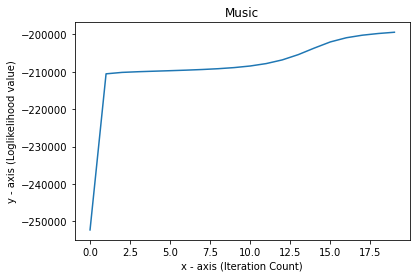

In [ ]:
prior = np.array([0.5, 0.5, 0.0])
mat = [[0.6, 0.4, 0.0], [0.3, 0.5, 0.2], [0.0, 0.1, 0.9]]
transition = np.array(mat)
mat = [[0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, 0.0],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0]]
emission = np.array(mat)

#Data preprocessing
SpeechData = readData('speech_music_classification/train/speech')
musicData = readData('speech_music_classification/train/music')

x=np.array([])
flag=0
for i in SpeechData:
    if flag==0:
        x=SpeechData[i]
        flag=1
    else:
        x = np.vstack((x, SpeechData[i]))
for i in musicData:
    x = np.vstack((x, musicData[i]))

MyKmeans = KMeans(n_clusters=8, init='k-means++', random_state=42).fit(x)
y_predict = MyKmeans.labels_
i=0
for j in range(0, 40*2998, 2998 ):
    SpeechData.update({i: y_predict[j:j+2998]})
    i=i+1
i=0
for j in range(40*2998, 2*40*2998, 2998 ):
    musicData.update({i: y_predict[j:j+2998]})
    i=i+1


speechPrior,speechTransition,speechEmission=EMAlgorithm(SpeechData, prior, emission, transition)
plot(finalLL.keys(), finalLL.values(), "Speech")

musicPrior,musicTransition,musicEmission=EMAlgorithm(musicData, prior, emission, transition)
plot(finalLL.keys(), finalLL.values(), "Music")


In [ ]:
#Testing
def readTestData(dire):
    orginalLabel = {}
    TestData = {}
    i = 0
    for fname in os.scandir(dire):
        if fname.is_file():
            orginalLabel.update({i: str(fname).split("_")[0]})
            rate, samples = wavfile.read(fname.path)
            temp = Spectro(rate, samples).T
            TestData.update({i: np.array(temp, copy=True)})
            i = i + 1
    return TestData,orginalLabel


testData,labels = readTestData('speech_music_classification/test')
y=np.array([])
flag=0
for i in testData:
    if flag==0:
        y=testData[i]
        flag=1
    else:
        y = np.vstack((y, testData[i]))
y=MyKmeans.predict(y)
i=0
for j in range(0, 48*2998, 2998 ):
    testData.update({i: y[j:j+2998]})
    i=i+1
sucess=0
for i in testData:
    dummy, prob1,c = forward(testData[i], speechPrior, speechEmission, speechTransition)
    dummy, prob2,c = forward(testData[i], musicPrior, musicEmission, musicTransition)
    if prob1>prob2:
        if "speech" in labels[i]:
            sucess+=1
    else:
        if "music" in labels[i]:
            sucess+=1
print("After classifying the test examples, the Accuracy rate is", (sucess/len(testData))*100)

After classifying the test examples, the Accuracy rate is 87.5
